# Imports

In [174]:
!pip install river
import yfinance as yf
from datetime import datetime, timedelta
from ta.momentum import RSIIndicator
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam


from river import metrics
from river import preprocessing
from river import linear_model
from river import tree
from river import forest


# Data Engineering

In [175]:

# Setting the end date to today and start date to 3 years before
end_date = datetime.now()
start_date = end_date - timedelta(days=365*3)

# Fetching stock data
google = yf.download('GOOGL', start=start_date, end=end_date)
facebook = yf.download('META', start=start_date, end=end_date)
amazon = yf.download('AMZN', start=start_date, end=end_date)

# Fetching global indices data
sp500 = yf.download('^GSPC', start=start_date, end=end_date)
cac40 = yf.download('^FCHI', start=start_date, end=end_date)
nikkei = yf.download('^N225', start=start_date, end=end_date)

# Preprocessing the data (example: using closing prices)
data = pd.DataFrame({
    'Google': google['Close'],
    'Facebook': facebook['Close'],
    'Amazon': amazon['Close'],
    'SP500': sp500['Close'],
    'CAC40': cac40['Close'],
    'Nikkei': nikkei['Close']
}).dropna()



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [176]:
data.dropna(inplace = True)
data

,Google,Facebook,Amazon,SP500,CAC40,Nikkei
Date,,,,,,
2021-01-12,86.871498,251.089996,156.041504,3801.189941,5650.970215,28164.339844
2021-01-13,87.362503,251.639999,158.294495,3809.840088,5662.669922,28456.589844
2021-01-14,86.545998,245.639999,156.373505,3795.540039,5681.140137,28698.259766
2021-01-15,86.380997,251.360001,155.212494,3768.250000,5611.689941,28519.179688
2021-01-19,89.223503,261.100006,156.037994,3798.909912,5598.609863,28633.460938
...,...,...,...,...,...,...
2024-01-04,136.389999,347.119995,144.570007,4688.680176,7450.629883,33288.289062
2024-01-05,135.729996,351.950012,145.240005,4697.240234,7420.689941,33377.421875
2024-01-09,140.949997,357.429993,151.369995,4756.500000,7426.620117,33763.179688


#### Feature engineering

In [177]:
def calculate_technical_indicators(data, companies=['Google', 'Amazon', 'Facebook']):
    """
    Calculate RSI and Moving Averages (SMA and EMA) for specified companies.
    """
    # Calculate RSI
    window_length_rsi = 14
    for company in companies:
        delta = data[company].diff()
        up = delta.clip(lower=0)
        down = -1 * delta.clip(upper=0)
        roll_up = up.rolling(window_length_rsi).mean()
        roll_down = down.rolling(window_length_rsi).mean()
        RS = roll_up / roll_down
        data[f'{company}_RSI'] = 100.0 - (100.0 / (1.0 + RS))

    # Calculate Moving Averages
    sma_ema_windows = [5, 10, 20]
    for company in companies:
        for window in sma_ema_windows:
            data[f'{company}_SMA_{window}'] = data[company].rolling(window=window).mean()
            data[f'{company}_EMA_{window}'] = data[company].ewm(span=window, adjust=False).mean()

    return data

updated_data = calculate_technical_indicators(data)

updated_data.dropna(inplace= True)


In [178]:
data = updated_data
data

,Google,Facebook,Amazon,SP500,CAC40,Nikkei,Google_RSI,Amazon_RSI,Facebook_RSI,Google_SMA_5,...,Amazon_SMA_10,Amazon_EMA_10,Amazon_SMA_20,Amazon_EMA_20,Facebook_SMA_5,Facebook_EMA_5,Facebook_SMA_10,Facebook_EMA_10,Facebook_SMA_20,Facebook_EMA_20
Date,,,,,,,,,,,,,,,,,,,,,
2021-02-09,103.769501,269.450012,165.250000,3911.229980,5691.540039,29505.929688,71.120237,53.781422,51.836659,103.612500,...,165.114499,165.268150,162.862074,163.352710,267.453998,267.648776,266.182999,266.936428,264.8785,264.512055
2021-02-10,104.323997,271.869995,164.328995,3909.879883,5670.799805,29562.929688,71.551520,48.056659,49.013029,103.888499,...,165.384499,165.097395,163.276449,163.445690,268.497998,269.055849,266.155997,267.833440,265.9175,265.212811
2021-02-12,104.751503,270.500000,163.885498,3934.830078,5703.669922,29520.070312,71.560006,48.601808,46.031748,104.302499,...,165.584949,164.877050,163.555999,163.487576,269.300000,269.537233,266.705997,268.318269,266.8605,265.716353
2021-02-16,105.535004,273.970001,163.447495,3932.590088,5786.529785,30467.750000,72.380563,47.619860,45.988873,104.521201,...,165.898698,164.617131,163.909698,163.483759,270.473999,271.014822,268.269998,269.345857,268.2770,266.502415
2021-02-17,105.931000,273.570007,165.432007,3931.330078,5765.839844,30292.189453,72.048140,48.361724,40.924685,104.862201,...,165.727499,164.765290,164.420674,163.669306,271.872003,271.866551,269.425998,270.113884,269.3875,267.175519
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-04,136.389999,347.119995,144.570007,4688.680176,7450.629883,33288.289062,53.932563,44.427086,62.300990,139.634000,...,152.044000,150.596693,149.382000,149.368617,354.123999,351.794457,350.388998,349.049823,338.5610,342.972241
2024-01-05,135.729996,351.950012,145.240005,4697.240234,7420.689941,33377.421875,57.279239,48.684757,73.910748,138.481998,...,151.571001,149.622750,149.292500,148.975416,353.835999,351.846309,352.091998,349.577130,339.9175,343.827267
2024-01-09,140.949997,357.429993,151.369995,4756.500000,7426.620117,33763.179688,69.872664,56.649568,72.185082,138.597998,...,151.300999,149.940431,149.619000,149.203471,353.756000,353.707537,353.372998,351.004923,341.7880,345.122764


# Batch Models

### Linear Regression

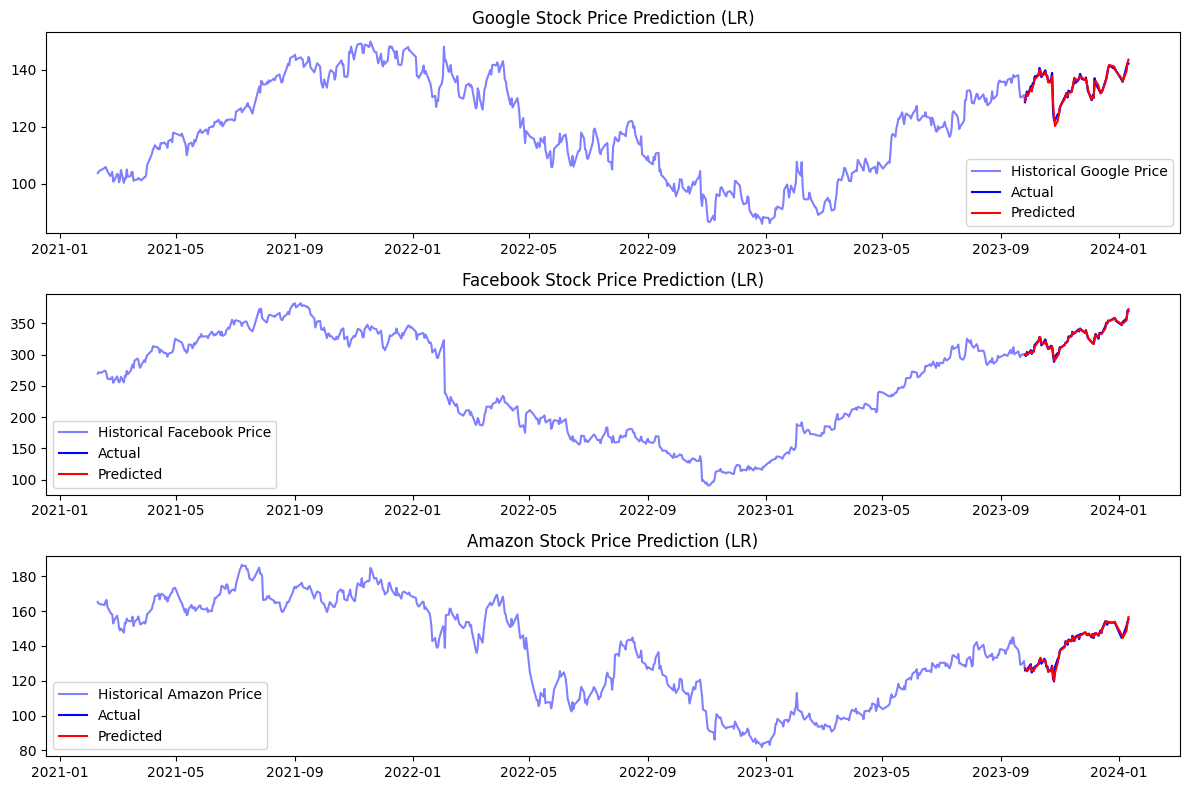

,Stock,Train MSE,Train R^2,Test MSE,Test R^2
0,Google,0.625784,0.997826,0.697810,0.968583
1,Facebook,5.606409,0.999126,3.899961,0.988851
2,Amazon,1.140484,0.998609,0.874038,0.991288


In [179]:
def create_and_evaluate_model(stock_name, data):
    # Feature selection
    features = data[['SP500', 'CAC40', 'Nikkei', f'{stock_name}_RSI', f'{stock_name}_SMA_5', f'{stock_name}_EMA_5', f'{stock_name}_SMA_10', f'{stock_name}_EMA_10', f'{stock_name}_SMA_20', f'{stock_name}_EMA_20']]
    target = data[stock_name]

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=42, shuffle=False)

    # Model training
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Predicting values
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluating the model
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    return train_mse, train_r2, test_mse, test_r2, y_test, y_test_pred

# Create and evaluate models for each stock
google_train_mse, google_train_r2, google_test_mse, google_test_r2, google_y_test, google_y_pred = create_and_evaluate_model('Google', data)
facebook_train_mse, facebook_train_r2, facebook_test_mse, facebook_test_r2, facebook_y_test, facebook_y_pred = create_and_evaluate_model('Facebook', data)
amazon_train_mse, amazon_train_r2, amazon_test_mse, amazon_test_r2, amazon_y_test, amazon_y_pred = create_and_evaluate_model('Amazon', data)

# Creating a DataFrame to hold the results
results_df = pd.DataFrame({
    'Stock': ['Google', 'Facebook', 'Amazon'],
    'Train MSE': [google_train_mse, facebook_train_mse, amazon_train_mse],
    'Train R^2': [google_train_r2, facebook_train_r2, amazon_train_r2],
    'Test MSE': [google_test_mse, facebook_test_mse, amazon_test_mse],
    'Test R^2': [google_test_r2, facebook_test_r2, amazon_test_r2]
})

# Plotting the predictions
plt.figure(figsize=(12, 8))

# Google
plt.subplot(3, 1, 1)
plt.plot(data.index, data['Google'], label=f'Historical Google Price', color='blue', alpha=0.5)
plt.plot(google_y_test.index, google_y_test, label='Actual', color='blue')
plt.plot(google_y_test.index, google_y_pred, label='Predicted', color='red')
plt.title('Google Stock Price Prediction (LR)')
plt.legend()

# Facebook
plt.subplot(3, 1, 2)
plt.plot(data.index, data['Facebook'], label=f'Historical Facebook Price', color='blue', alpha=0.5)
plt.plot(facebook_y_test.index, facebook_y_test, label='Actual', color='blue')
plt.plot(facebook_y_test.index, facebook_y_pred, label='Predicted', color='red')
plt.title('Facebook Stock Price Prediction (LR)')
plt.legend()

# Amazon
plt.subplot(3, 1, 3)
plt.plot(data.index, data['Amazon'], label=f'Historical Amazon Price', color='blue', alpha=0.5)
plt.plot(amazon_y_test.index, amazon_y_test, label='Actual', color='blue')
plt.plot(amazon_y_test.index, amazon_y_pred, label='Predicted', color='red')
plt.title('Amazon Stock Price Prediction (LR)')
plt.legend()

plt.tight_layout()
plt.show()


results_df

## XGboost

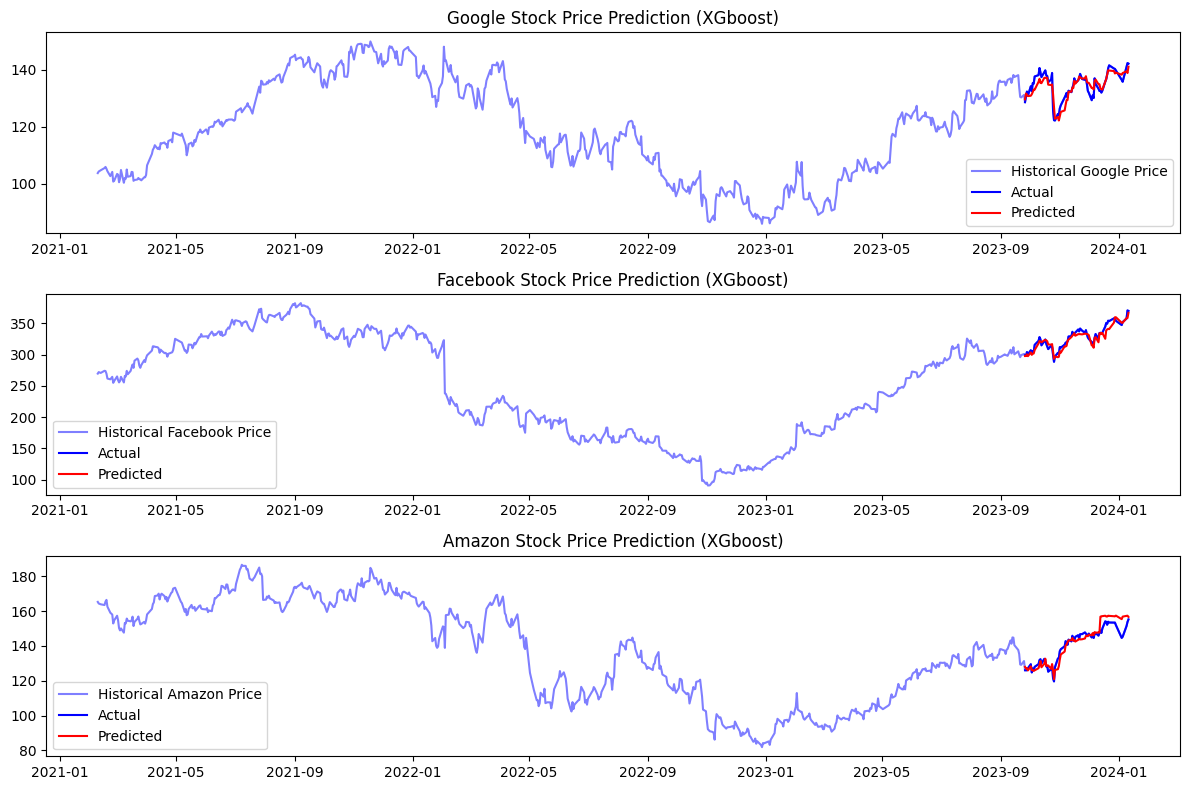

,Stock,Train MSE,Train R^2,Test MSE,Test R^2
0,Google,0.002259,0.999992,4.954612,0.776933
1,Facebook,0.032909,0.999995,35.153898,0.899504
2,Amazon,0.005710,0.999993,12.745537,0.872962


In [180]:

def create_and_evaluate_model(stock_name, data):
    # Feature selection
    features = data[['SP500', 'CAC40', 'Nikkei', f'{stock_name}_RSI', f'{stock_name}_SMA_5', f'{stock_name}_EMA_5', f'{stock_name}_SMA_10', f'{stock_name}_EMA_10', f'{stock_name}_SMA_20', f'{stock_name}_EMA_20']]
    target = data[stock_name]

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=42, shuffle=False)

    # Model training (using XGBoost)
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X_train, y_train)

    # Predicting values
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluating the model
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    return train_mse, train_r2, test_mse, test_r2, y_test, y_test_pred

# Create and evaluate models for each stock
google_train_mse, google_train_r2, google_test_mse, google_test_r2, google_y_test, google_y_pred = create_and_evaluate_model('Google', data)
facebook_train_mse, facebook_train_r2, facebook_test_mse, facebook_test_r2, facebook_y_test, facebook_y_pred = create_and_evaluate_model('Facebook', data)
amazon_train_mse, amazon_train_r2, amazon_test_mse, amazon_test_r2, amazon_y_test, amazon_y_pred = create_and_evaluate_model('Amazon', data)

# Creating a DataFrame to hold the results
results_df = pd.DataFrame({
    'Stock': ['Google', 'Facebook', 'Amazon'],
    'Train MSE': [google_train_mse, facebook_train_mse, amazon_train_mse],
    'Train R^2': [google_train_r2, facebook_train_r2, amazon_train_r2],
    'Test MSE': [google_test_mse, facebook_test_mse, amazon_test_mse],
    'Test R^2': [google_test_r2, facebook_test_r2, amazon_test_r2]
})

# Plotting the predictions
plt.figure(figsize=(12, 8))

# Google
plt.subplot(3, 1, 1)
plt.plot(data.index, data['Google'], label=f'Historical Google Price', color='blue', alpha=0.5)
plt.plot(google_y_test.index, google_y_test, label='Actual', color='blue')
plt.plot(google_y_test.index, google_y_pred, label='Predicted', color='red')
plt.title('Google Stock Price Prediction (XGboost)')
plt.legend()

# Facebook
plt.subplot(3, 1, 2)
plt.plot(data.index, data['Facebook'], label=f'Historical Facebook Price', color='blue', alpha=0.5)
plt.plot(facebook_y_test.index, facebook_y_test, label='Actual', color='blue')
plt.plot(facebook_y_test.index, facebook_y_pred, label='Predicted', color='red')
plt.title('Facebook Stock Price Prediction (XGboost)')
plt.legend()

# Amazon
plt.subplot(3, 1, 3)
plt.plot(data.index, data['Amazon'], label=f'Historical Amazon Price', color='blue', alpha=0.5)
plt.plot(amazon_y_test.index, amazon_y_test, label='Actual', color='blue')
plt.plot(amazon_y_test.index, amazon_y_pred, label='Predicted', color='red')
plt.title('Amazon Stock Price Prediction (XGboost)')
plt.legend()

plt.tight_layout()
plt.show()

results_df


## LSTM

Epoch 1/50
20/20 [==============================] - 6s 4ms/step - loss: 0.2882
Epoch 2/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0608
Epoch 3/50
20/20 [==============================] - 0s 10ms/step - loss: 0.0072
Epoch 4/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0060
Epoch 5/50
20/20 [==============================] - 0s 8ms/step - loss: 0.0047
Epoch 6/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0041
Epoch 7/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0036
Epoch 8/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0032
Epoch 9/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0029
Epoch 10/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0026
Epoch 11/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0024
Epoch 12/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0023
Epoch 13/50
20/20 [=============================

Epoch 1/50
20/20 [==============================] - 8s 12ms/step - loss: 0.1590
Epoch 2/50
20/20 [==============================] - 0s 13ms/step - loss: 0.0227
Epoch 3/50
20/20 [==============================] - 0s 4ms/step - loss: 0.0135
Epoch 4/50
20/20 [==============================] - 0s 5ms/step - loss: 0.0098
Epoch 5/50
20/20 [==============================] - 0s 17ms/step - loss: 0.0077
Epoch 6/50
20/20 [==============================] - 0s 15ms/step - loss: 0.0059
Epoch 7/50
20/20 [==============================] - 0s 18ms/step - loss: 0.0045
Epoch 8/50
20/20 [==============================] - 0s 15ms/step - loss: 0.0035
Epoch 9/50
20/20 [==============================] - 0s 19ms/step - loss: 0.0028
Epoch 10/50
20/20 [==============================] - 0s 13ms/step - loss: 0.0023
Epoch 11/50
20/20 [==============================] - 0s 19ms/step - loss: 0.0019
Epoch 12/50
20/20 [==============================] - 0s 19ms/step - loss: 0.0016
Epoch 13/50
20/20 [====================

Epoch 1/50
20/20 [==============================] - 2s 4ms/step - loss: 0.2308
Epoch 2/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0312
Epoch 3/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0096
Epoch 4/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0064
Epoch 5/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0048
Epoch 6/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0036
Epoch 7/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0028
Epoch 8/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0022
Epoch 9/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0018
Epoch 10/50
20/20 [==============================] - 0s 2ms/step - loss: 0.0016
Epoch 11/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0015
Epoch 12/50
20/20 [==============================] - 0s 3ms/step - loss: 0.0014
Epoch 13/50
20/20 [==============================

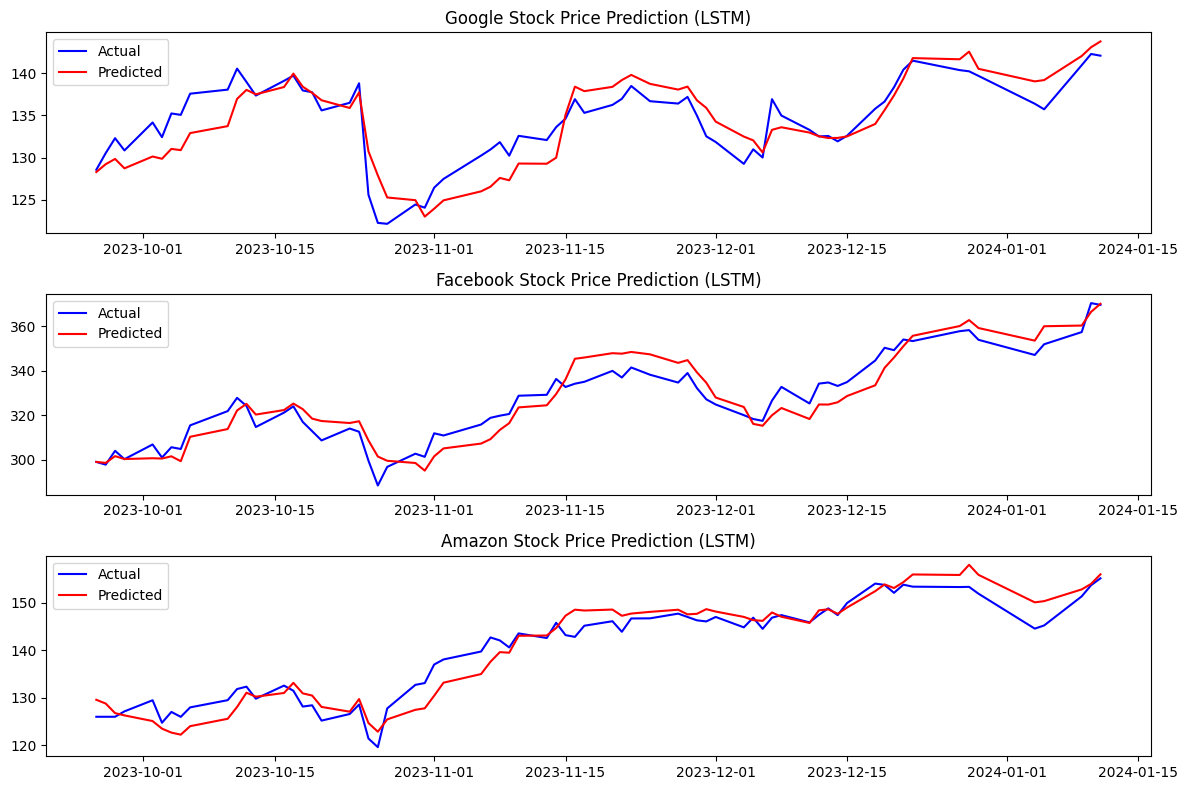

,Stock,Train MSE,Train R^2,Test MSE,Test R^2
0,Google,3.997712,0.986109,6.082586,0.726149
1,Facebook,42.068503,0.993441,42.012870,0.879896
2,Amazon,10.459320,0.987243,8.336363,0.916909


In [181]:


def create_and_evaluate_lstm_model(stock_name, data):
    # Feature selection
    features = data[['SP500', 'CAC40', 'Nikkei', f'{stock_name}_RSI', f'{stock_name}_SMA_5', f'{stock_name}_EMA_5', f'{stock_name}_SMA_10', f'{stock_name}_EMA_10', f'{stock_name}_SMA_20', f'{stock_name}_EMA_20']]
    target = data[stock_name]

    # Normalize the data
    scaler = MinMaxScaler()
    features = scaler.fit_transform(features)
    target = scaler.fit_transform(target.values.reshape(-1, 1))

    # Splitting the dataset
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.1, random_state=42, shuffle=False)

    # Reshape data for LSTM
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    # Create an LSTM model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))

    # Model training
    model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

    # Predicting values
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Inverse transform to get original scale
    y_train_pred = scaler.inverse_transform(y_train_pred)
    y_test_pred = scaler.inverse_transform(y_test_pred)
    y_train = scaler.inverse_transform(y_train)
    y_test = scaler.inverse_transform(y_test)

    # Evaluating the model
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    return train_mse, train_r2, test_mse, test_r2, y_test, y_test_pred

# Create and evaluate LSTM models for each stock
google_train_mse, google_train_r2, google_test_mse, google_test_r2, google_y_test, google_y_pred = create_and_evaluate_lstm_model('Google', data)
facebook_train_mse, facebook_train_r2, facebook_test_mse, facebook_test_r2, facebook_y_test, facebook_y_pred = create_and_evaluate_lstm_model('Facebook', data)
amazon_train_mse, amazon_train_r2, amazon_test_mse, amazon_test_r2, amazon_y_test, amazon_y_pred = create_and_evaluate_lstm_model('Amazon', data)

# Creating a DataFrame to hold the results
results_df = pd.DataFrame({
    'Stock': ['Google', 'Facebook', 'Amazon'],
    'Train MSE': [google_train_mse, facebook_train_mse, amazon_train_mse],
    'Train R^2': [google_train_r2, facebook_train_r2, amazon_train_r2],
    'Test MSE': [google_test_mse, facebook_test_mse, amazon_test_mse],
    'Test R^2': [google_test_r2, facebook_test_r2, amazon_test_r2]
})

# Plotting the predictions
plt.figure(figsize=(12, 8))


# Google
plt.subplot(3, 1, 1)
plt.plot(data.index[-len(google_y_test):], google_y_test, label='Actual', color='blue')
plt.plot(data.index[-len(google_y_test):], google_y_pred, label='Predicted', color='red')
plt.title('Google Stock Price Prediction (LSTM)')
plt.legend()

# Facebook
plt.subplot(3, 1, 2)
plt.plot(data.index[-len(facebook_y_test):], facebook_y_test, label='Actual', color='blue')
plt.plot(data.index[-len(facebook_y_test):], facebook_y_pred, label='Predicted', color='red')
plt.title('Facebook Stock Price Prediction (LSTM)')
plt.legend()

# Amazon
plt.subplot(3, 1, 3)
plt.plot(data.index[-len(amazon_y_test):], amazon_y_test, label='Actual', color='blue')
plt.plot(data.index[-len(amazon_y_test):], amazon_y_pred, label='Predicted', color='red')
plt.title('Amazon Stock Price Prediction (LSTM)')
plt.legend()

plt.tight_layout()
plt.show()

results_df


# Online Models

## LinearRegression

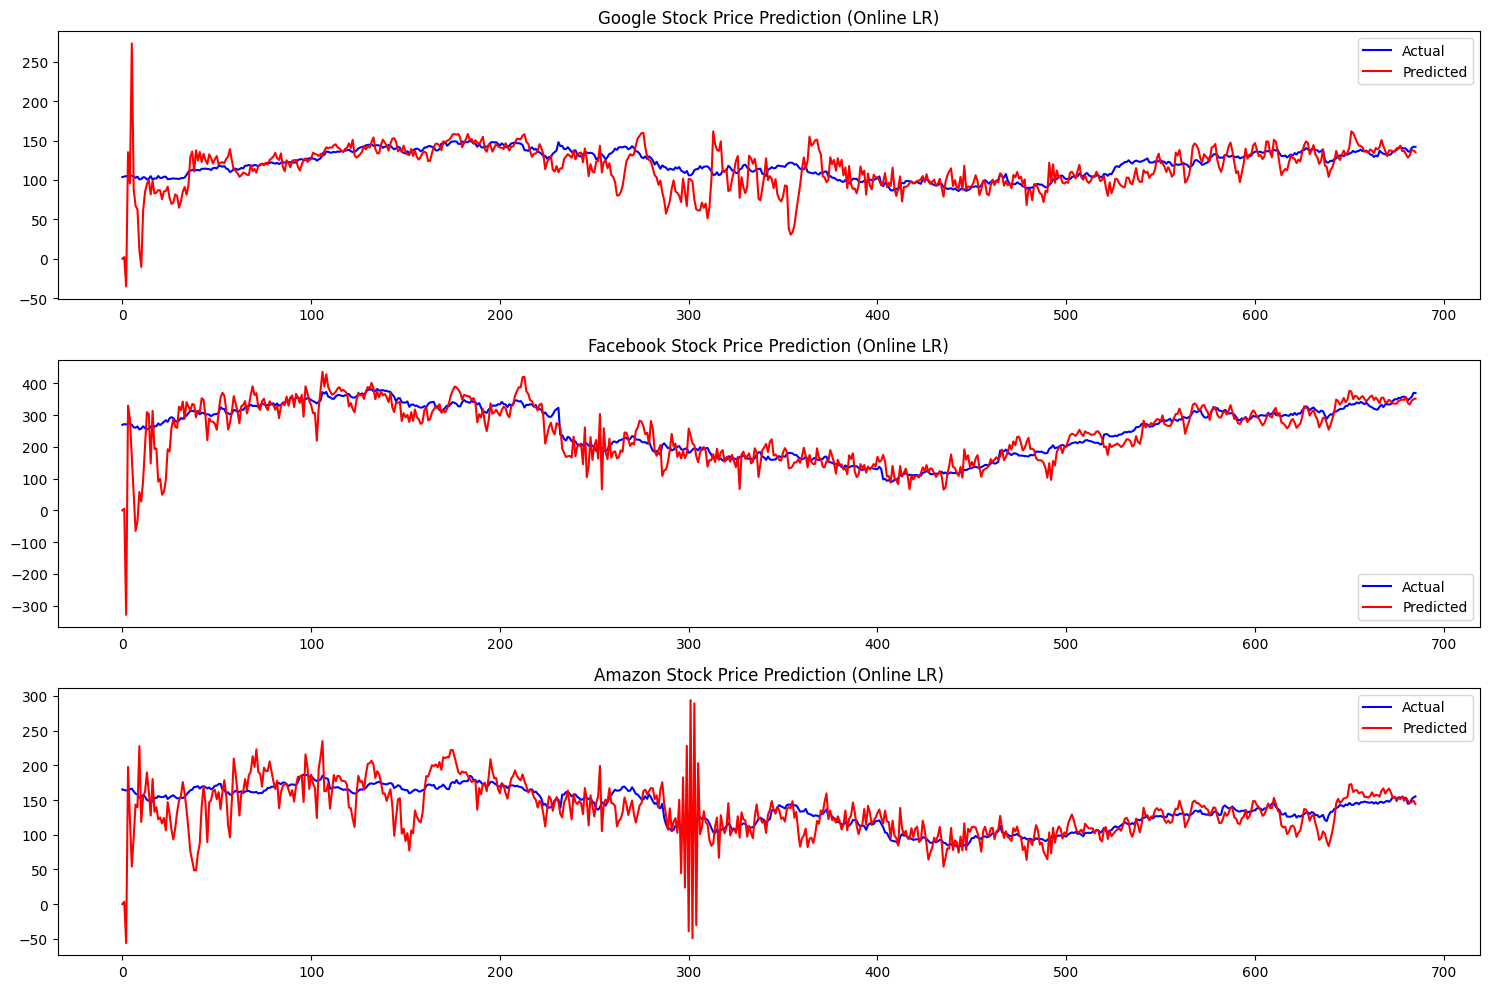

,Stock,MSE,MA,R^2
0,Google,454.970296,13.476956,-0.607308
1,Facebook,2566.834155,29.399389,0.597606
2,Amazon,930.827439,18.538711,-0.244014


In [182]:
def create_and_evaluate_online_model(stock_name, data):

    feature_cols = [f'{stock_name}_RSI', f'{stock_name}_SMA_5', f'{stock_name}_EMA_5', f'{stock_name}_SMA_10', f'{stock_name}_EMA_10', f'{stock_name}_SMA_20', f'{stock_name}_EMA_20', 'SP500', 'CAC40', 'Nikkei']
    target_col = stock_name

    model = preprocessing.StandardScaler() | linear_model.LinearRegression()

    mse_metric = metrics.MSE()
    r2_metric = metrics.R2()
    ma_metric = metrics.MAE()

    predictions, actuals = [], []
    data_stream = ((row[feature_cols], row[target_col]) for _, row in data.iterrows())

    for x, y in data_stream:
        y_pred = model.predict_one(x)
        model.learn_one(x, y)
        mse_metric.update(y, y_pred)
        r2_metric.update(y, y_pred)
        ma_metric.update(y, y_pred)
        predictions.append(y_pred)
        actuals.append(y)

    return predictions, actuals, mse_metric.get(), r2_metric.get(), ma_metric.get()


google_predictions, google_actuals, google_mse, google_r2, google_ma = create_and_evaluate_online_model('Google', data)
facebook_predictions, facebook_actuals, facebook_mse, facebook_r2, facebook_ma = create_and_evaluate_online_model('Facebook', data)
amazon_predictions, amazon_actuals, amazon_mse, amazon_r2, amazon_ma = create_and_evaluate_online_model('Amazon', data)

plt.figure(figsize=(15, 10))

# Google
plt.subplot(3, 1, 1)
plt.plot(google_actuals, label='Actual', color='blue')
plt.plot(google_predictions, label='Predicted', color='red')
plt.title('Google Stock Price Prediction (Online LR)')
plt.legend()

# Facebook
plt.subplot(3, 1, 2)
plt.plot(facebook_actuals, label='Actual', color='blue')
plt.plot(facebook_predictions, label='Predicted', color='red')
plt.title('Facebook Stock Price Prediction (Online LR)')
plt.legend()

# Amazon
plt.subplot(3, 1, 3)
plt.plot(amazon_actuals, label='Actual', color='blue')
plt.plot(amazon_predictions, label='Predicted', color='red')
plt.title('Amazon Stock Price Prediction (Online LR)')
plt.legend()

plt.tight_layout()
plt.show()

# Creating a DataFrame with results
results_df_online_LR = pd.DataFrame({
    'Stock': ['Google', 'Facebook', 'Amazon'],
    'MSE': [google_mse, facebook_mse, amazon_mse],
    'MA' : [google_ma, facebook_ma, amazon_ma],
    'R^2': [google_r2, facebook_r2, amazon_r2]
})
results_df_online_LR


## HoeffdingTreeRegressor

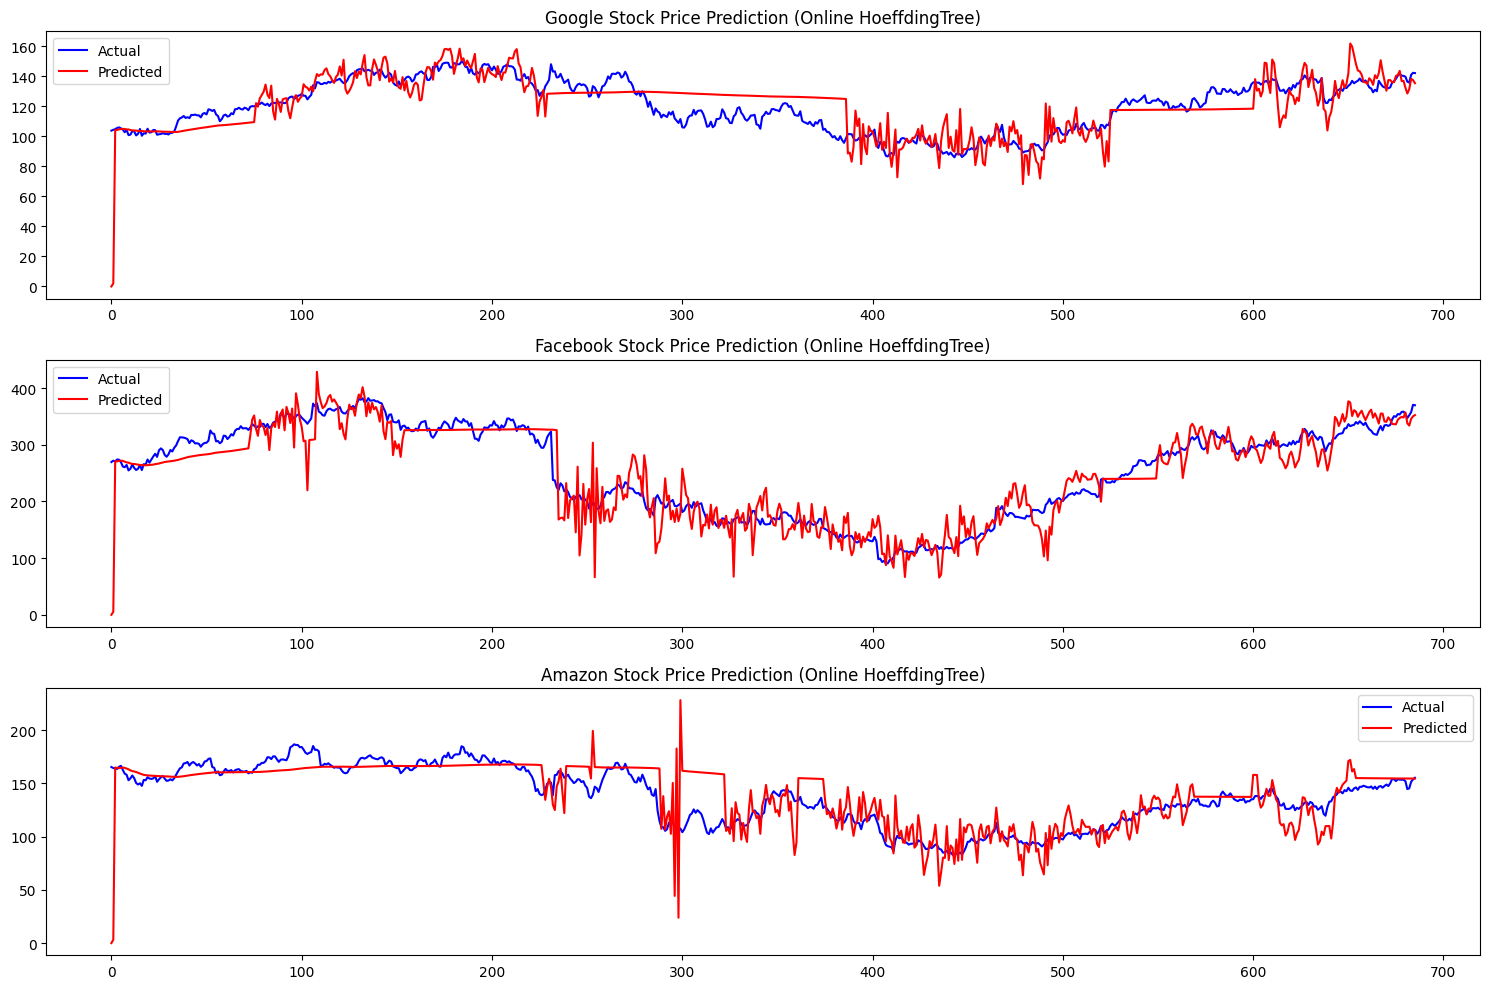

,Stock,MSE,MA,R^2
0,Google,132.760389,8.300439,0.530987
1,Facebook,1002.564208,21.807516,0.842831
2,Amazon,350.416952,11.515859,0.531682


In [183]:

def create_and_evaluate_online_model(stock_name, data):

    feature_cols = [f'{stock_name}_RSI', f'{stock_name}_SMA_5', f'{stock_name}_EMA_5', f'{stock_name}_SMA_10', f'{stock_name}_EMA_10', f'{stock_name}_SMA_20', f'{stock_name}_EMA_20', 'SP500', 'CAC40', 'Nikkei']
    target_col = stock_name


    model = (
    preprocessing.StandardScaler() |
    tree.HoeffdingTreeRegressor(
        grace_period=100,
        model_selector_decay=0.9)
    )


    mse_metric = metrics.MSE()
    r2_metric = metrics.R2()
    ma_metric = metrics.MAE()

    predictions, actuals = [], []
    data_stream = ((row[feature_cols], row[target_col]) for _, row in data.iterrows())

    for x, y in data_stream:
        y_pred = model.predict_one(x)
        model.learn_one(x, y)
        mse_metric.update(y, y_pred)
        r2_metric.update(y, y_pred)
        ma_metric.update(y, y_pred)
        predictions.append(y_pred)
        actuals.append(y)

    return predictions, actuals, mse_metric.get(), r2_metric.get(), ma_metric.get()


google_predictions, google_actuals, google_mse, google_r2, google_ma = create_and_evaluate_online_model('Google', data)
facebook_predictions, facebook_actuals, facebook_mse, facebook_r2, facebook_ma = create_and_evaluate_online_model('Facebook', data)
amazon_predictions, amazon_actuals, amazon_mse, amazon_r2, amazon_ma = create_and_evaluate_online_model('Amazon', data)

plt.figure(figsize=(15, 10))

# Google
plt.subplot(3, 1, 1)
plt.plot(google_actuals, label='Actual', color='blue')
plt.plot(google_predictions, label='Predicted', color='red')
plt.title('Google Stock Price Prediction (Online HoeffdingTree)')
plt.legend()

# Facebook
plt.subplot(3, 1, 2)
plt.plot(facebook_actuals, label='Actual', color='blue')
plt.plot(facebook_predictions, label='Predicted', color='red')
plt.title('Facebook Stock Price Prediction (Online HoeffdingTree)')
plt.legend()

# Amazon
plt.subplot(3, 1, 3)
plt.plot(amazon_actuals, label='Actual', color='blue')
plt.plot(amazon_predictions, label='Predicted', color='red')
plt.title('Amazon Stock Price Prediction (Online HoeffdingTree)')
plt.legend()

plt.tight_layout()
plt.show()

# Creating a DataFrame with results
results_df_online_HTR = pd.DataFrame({
    'Stock': ['Google', 'Facebook', 'Amazon'],
    'MSE': [google_mse, facebook_mse, amazon_mse],
    'MA' : [google_ma, facebook_ma, amazon_ma],
    'R^2': [google_r2, facebook_r2, amazon_r2]
})

results_df_online_HTR

## ARFRegressor

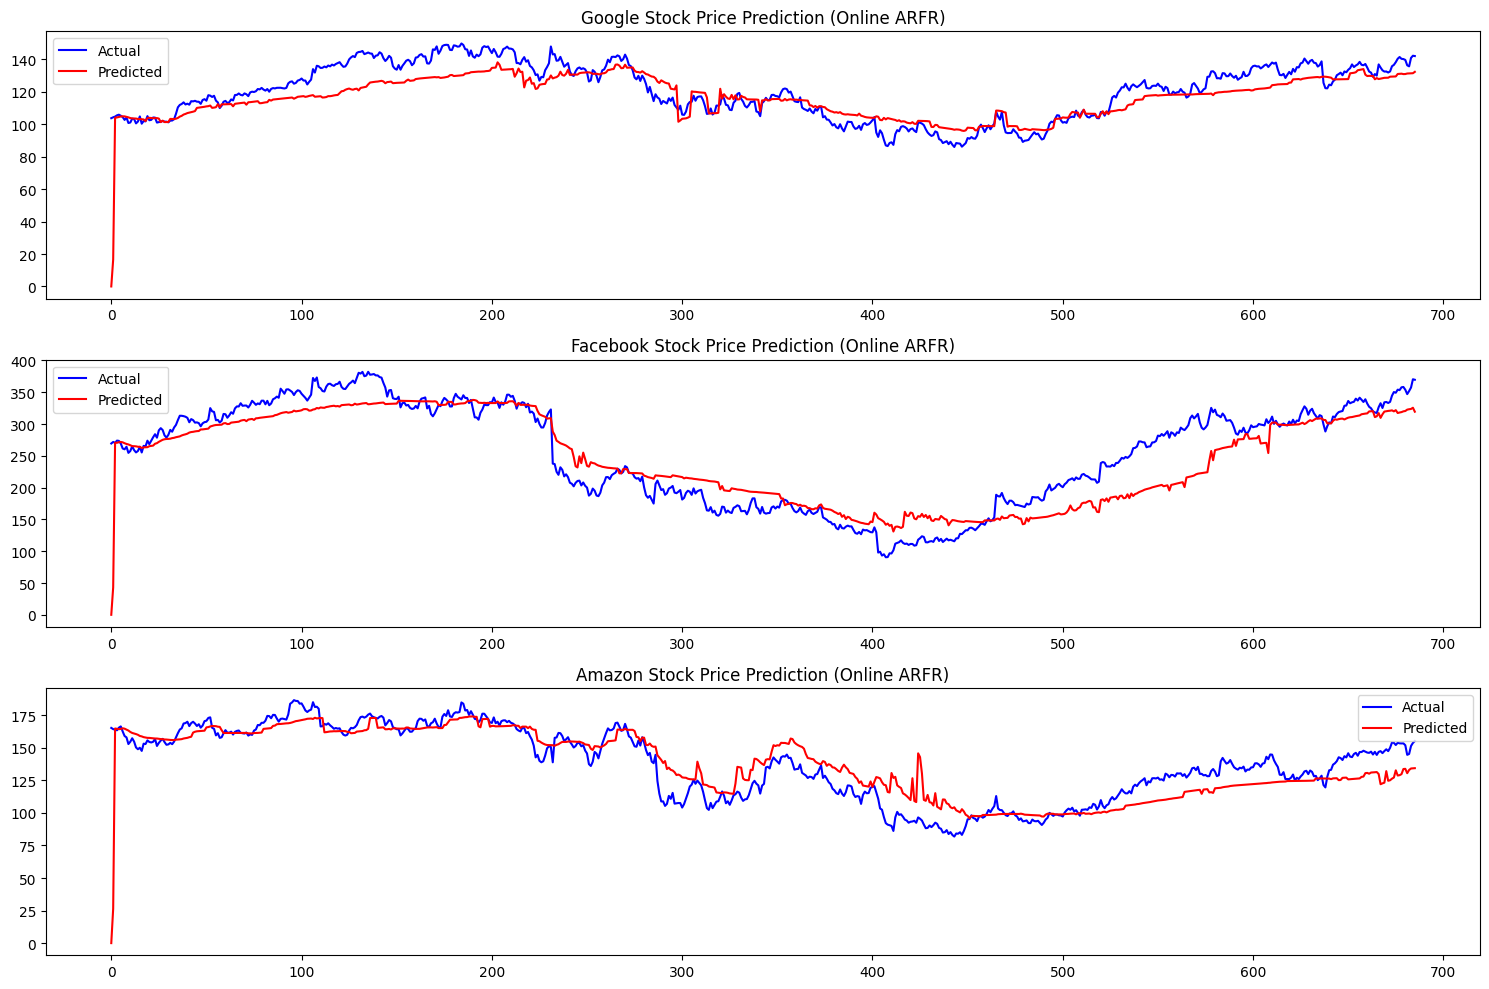

,Stock,MSE,MA,R^2
0,Google,103.808719,7.359819,0.633267
1,Facebook,1294.941667,27.168212,0.796996
2,Amazon,219.978965,10.060807,0.706007


In [184]:
def create_and_evaluate_online_model(stock_name, data):

    feature_cols = [f'{stock_name}_RSI', f'{stock_name}_SMA_5', f'{stock_name}_EMA_5', f'{stock_name}_SMA_10', f'{stock_name}_EMA_10', f'{stock_name}_SMA_20', f'{stock_name}_EMA_20', 'SP500', 'CAC40', 'Nikkei']
    target_col = stock_name


    model = (
    preprocessing.StandardScaler() |
    forest.ARFRegressor(seed=42)
    )

    mse_metric = metrics.MSE()
    r2_metric = metrics.R2()
    ma_metric = metrics.MAE()


    predictions, actuals = [], []
    data_stream = ((row[feature_cols], row[target_col]) for _, row in data.iterrows())

    for x, y in data_stream:
        y_pred = model.predict_one(x)
        model.learn_one(x, y)
        mse_metric.update(y, y_pred)
        r2_metric.update(y, y_pred)
        ma_metric.update(y, y_pred)
        predictions.append(y_pred)
        actuals.append(y)

    return predictions, actuals, mse_metric.get(), r2_metric.get(), ma_metric.get()


google_predictions, google_actuals, google_mse, google_r2, google_ma = create_and_evaluate_online_model('Google', data)
facebook_predictions, facebook_actuals, facebook_mse, facebook_r2, facebook_ma = create_and_evaluate_online_model('Facebook', data)
amazon_predictions, amazon_actuals, amazon_mse, amazon_r2, amazon_ma = create_and_evaluate_online_model('Amazon', data)

plt.figure(figsize=(15, 10))

# Google
plt.subplot(3, 1, 1)
plt.plot(google_actuals, label='Actual', color='blue')
plt.plot(google_predictions, label='Predicted', color='red')
plt.title('Google Stock Price Prediction (Online ARFR)')
plt.legend()

# Facebook
plt.subplot(3, 1, 2)
plt.plot(facebook_actuals, label='Actual', color='blue')
plt.plot(facebook_predictions, label='Predicted', color='red')
plt.title('Facebook Stock Price Prediction (Online ARFR)')
plt.legend()

# Amazon
plt.subplot(3, 1, 3)
plt.plot(amazon_actuals, label='Actual', color='blue')
plt.plot(amazon_predictions, label='Predicted', color='red')
plt.title('Amazon Stock Price Prediction (Online ARFR)')
plt.legend()

plt.tight_layout()
plt.show()

# Creating a DataFrame with results
results_df_online_AFR = pd.DataFrame({
    'Stock': ['Google', 'Facebook', 'Amazon'],
    'MSE': [google_mse, facebook_mse, amazon_mse],
    'MA' : [google_ma, facebook_ma, amazon_ma],
    'R^2': [google_r2, facebook_r2, amazon_r2]
})

results_df_online_AFR